In this notebook, we assign the CpG sites to the nearest genes and also assess enrichment for genic features and also for Enhancers. We looked at more, but since Enhancers showed the greatest enrichment and since many of these histone features are often overlapping, we wanted to specifically look at Enhancers in the context of other genic features (promoters, intronic, exonic and intergenic regions).

In [1]:
from __future__ import division
import os
import numpy as np
import random 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline
import itertools

import imp
twto = imp.load_source('twto','scripts/twang_toolbox.py')
meth = imp.load_source('meth','scripts/methy_parsing.py')

from sklearn import cross_validation, linear_model, metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats as smstats
import scipy.stats as stats
import scipy.cluster.hierarchy as hac

In [2]:
#Used in paper
sns.set(context = "paper", style='ticks',rc={"font.size":9,"legend.fontsize":8,"axes.titlesize":12,
                             "axes.labelsize":8,"xtick.labelsize":6,"ytick.labelsize":6, 'xtick.major.size': 3.0,
 'xtick.minor.size': 1.0,'ytick.major.size': 3.0,
 'ytick.minor.size': 1.0})

In [3]:
sns.set(context='notebook',style='ticks')

In [4]:
cpg_sites_f = 'data/epigenetic_aging_model/EnetSites_with_weights.txt'
cpg_sites_weights = pd.read_csv(cpg_sites_f,sep='\t',header=None,index_col=None,names=['ConcatSite','Weight'])

In [5]:
cpg_sites_weights.head()

,ConcatSite,Weight
0,10:127750968:127750969,0.115239
1,10:67548087:67548088,0.153033
2,10:80810498:80810499,0.148354
3,10:80971848:80971849,-0.223936
4,10:80971894:80971895,-0.686181


Ran closestBed with the bed format of the epigenetic aging sites, and using the mapped version of Ensembl67 gene names (mm9 to mm10), this was done to keep the same gene annotation as what was used in Supplementary Figure 1, and also kept epigenomic features because I thought it might be interesting if the site fell into this region. The output of this process was saved in 'data/epigenetic_aging_model/EnetSites_intersectedFeatures.txt'

In [6]:
closest_bed = 'data/epigenetic_aging_model/EnetSites_intersectedFeatures.txt'
df_closest_features = pd.read_csv(closest_bed,sep='\t',header=None,index_col=None)

In [7]:
df_closest_features.columns = ['chr','start','stop','filename','chr_feature','start_feature','stop_feature','geneName','distance']

In [8]:
index_null = df_closest_features[df_closest_features['distance'].isnull()].index
df_closest_features_format = df_closest_features.copy(deep=True)
df_closest_features_format.loc[index_null,'distance'] = df_closest_features_format.loc[index_null,'geneName'].astype(int)
df_closest_features_format.loc[index_null,'geneName'] = np.nan

In [9]:
df_closest_features_format['ConcatSite'] =[':'.join(map(lambda y: str(y),x)) for x in df_closest_features_format[['chr','start','stop']].values]

In [10]:
df_closest_features_format_overlap = df_closest_features_format[df_closest_features_format['distance']==0]

In [11]:
#df_closest_features_overlapping[['chr','start','stop']].drop_duplicates()
#125 unique overlapping sites, meaning 23 are somewhere else
unique_sites_overlapping = df_closest_features_format_overlap['ConcatSite'].unique()

In [12]:
df_not_overlapping = df_closest_features_format.loc[~df_closest_features_format['ConcatSite'].isin(unique_sites_overlapping)]

For the sites overlapping an annotation, there could be several genes or other features. I will try and parse them out for each CpG site by whether they are a gene and/or in a feature as well. Then for the not overlapping sites, I will choose the closest feature, either by gene or other genomic feature, and fill it in. If there are ties, gene will get priority and then other features.

In [13]:
df_closest_features_format_overlap['filename'] = [x.split('_mapped.bed.sorted')[0] for x in df_closest_features_format_overlap['filename'].values]

/cellar/users/twang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
pivot_features = []
for k, grp in df_closest_features_format_overlap.groupby('ConcatSite'):
    histone_features = '; '.join([x.split('_')[0] for x in grp.loc[grp['filename'] !='EnsemblExons67.KnownCodingGenes.GeneNames','filename'].values])
    gene_names = '; '.join(grp.loc[grp['filename'] =='EnsemblExons67.KnownCodingGenes.GeneNames','geneName'].values)
    pivot_features.append([k,gene_names,histone_features,0,0])
pivot_features = pd.DataFrame(pivot_features,columns=['ConcatSite','nearest_genes','nearest_HistoneFeatures','gene_distance','nearest_histone_distance'])

In [15]:
#Converting Ensembl gene IDs to MGI gene symbols with description
gene_name_f = 'data/epigenetic_aging_model/Ensembl67Gene_to_MGI_GeneSymbol.txt'
gene_name_df = pd.read_csv(gene_name_f,sep='\t',header=0,index_col=None)
gene_name_to_mgiSy = {x[0]:['',x[1]][x[1] not in [np.nan]] for x in gene_name_df[['Ensembl Gene ID','MGI symbol']].values}
gene_name_to_mgiDesc = {x[0]:['',x[1]][x[1] not in [np.nan]] for x in gene_name_df[['Ensembl Gene ID','MGI Description']].values}
pivot_features['MGI Name'] = [[x,'; '.join([gene_name_to_mgiSy[y] for y in x.split('; ') if x !=''])][x!=''] for x in pivot_features['nearest_genes'].values]
pivot_features['MGI Description'] = [[x,'; '.join([gene_name_to_mgiDesc[y] for y in x.split('; ') if x !=''])][x!=''] for x in pivot_features['nearest_genes'].values]

In [16]:
#For regions where nearest_genes are blank, we fill with the closest Gene if present
index_null_genes = pivot_features.loc[pivot_features['nearest_genes'] == '','ConcatSite']
#Fill in null genes with their ensembl ID for closest if it exists
nearest_genes_overlapping_others = df_closest_features_format[(df_closest_features_format['ConcatSite'].isin(index_null_genes)) & (df_closest_features_format['filename'].str.startswith('EnsemblExon'))]
map_site2gene = {k:val for k,val in nearest_genes_overlapping_others[['ConcatSite','geneName']].values}
map_site2genedist = {k:val for k,val in nearest_genes_overlapping_others[['ConcatSite','distance']].values}

In [17]:
pivot_features.loc[pivot_features['ConcatSite'].isin(index_null_genes),'nearest_genes'] = pivot_features.loc[pivot_features['ConcatSite'].isin(index_null_genes),'ConcatSite'].map(map_site2gene)
pivot_features.loc[pivot_features['ConcatSite'].isin(index_null_genes),'gene_distance'] = pivot_features.loc[pivot_features['ConcatSite'].isin(index_null_genes),'ConcatSite'].map(map_site2genedist)
pivot_features.loc[pivot_features['ConcatSite'].isin(index_null_genes),'MGI Name'] = [[x,'; '.join([gene_name_to_mgiSy[y] for y in x.split('; ') if x !=''])][x!=''] for x in pivot_features.loc[pivot_features['ConcatSite'].isin(index_null_genes),'nearest_genes'].values]
pivot_features.loc[pivot_features['ConcatSite'].isin(index_null_genes),'MGI Description'] = [[x,'; '.join([gene_name_to_mgiDesc[y] for y in x.split('; ') if x !=''])][x!=''] for x in pivot_features.loc[pivot_features['ConcatSite'].isin(index_null_genes),'nearest_genes'].values]

In [19]:
#Find index corresponding to null histones and set their distance to none
#This was done because it is unclear if there is a biological effect of being near a histone feature versus directly overlapping the boundaries
#Thus, we have chosen to omit this. 
index_null_histones = pivot_features.loc[pivot_features['nearest_HistoneFeatures'] == '','ConcatSite']
pivot_features.loc[pivot_features['ConcatSite'].isin(index_null_histones),'nearest_histone_distance'] = np.nan

In [20]:
#Rename columns
pivot_features.columns = ['ConcatSite','nearest_gene','HistoneFeatures','nearest_gene_distance','histone_distance','MGI Name','MGI Description']

In [21]:
pivot_features.head()

,ConcatSite,nearest_gene,HistoneFeatures,nearest_gene_distance,histone_distance,MGI Name,MGI Description
0,10:127750968:127750969,ENSMUSG00000058396,Enhancers; H3K27ac; H3K36me3; H3K4me1; H3K4me3...,0.0,0.0,Gpr182,G protein-coupled receptor 182
1,10:67548087:67548088,ENSMUSG00000057134,Enhancers; H3K27ac; H3K4me1; H3K4me3; H3K79me2...,0.0,0.0,Ado,2-aminoethanethiol (cysteamine) dioxygenase
2,10:80810498:80810499,ENSMUSG00000020216,H3K27me3,0.0,0.0,Jsrp1,junctional sarcoplasmic reticulum protein 1
3,10:80971848:80971849,ENSMUSG00000048240,Enhancers; H3K27ac; H3K4me1; H3K9ac,0.0,0.0,Gng7,guanine nucleotide binding protein (G protein)...
4,10:80971894:80971895,ENSMUSG00000048240,Enhancers; H3K27ac; H3K4me1; H3K9ac,0.0,0.0,Gng7,guanine nucleotide binding protein (G protein)...


Pick the closest gene for not overlapping sites

In [22]:
df_not_overlapping['filename'] = [x.split('_mapped.bed.sorted')[0] for x in df_not_overlapping['filename'].values]

/cellar/users/twang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
df_not_overlapping.head()

,chr,start,stop,filename,chr_feature,start_feature,stop_feature,geneName,distance,ConcatSite
198,11,114655827,114655828,EnsemblExons67.KnownCodingGenes.GeneNames,11,114668524,114672331,ENSMUSG00000057322,12697.0,11:114655827:114655828
199,11,114655827,114655828,Bivalent,11,114789086,114789485,NaN,133259.0,11:114655827:114655828
200,11,114655827,114655828,DNase_8w_rep2,11,114667966,114668116,NaN,12139.0,11:114655827:114655828
201,11,114655827,114655828,Enhancers,11,114669086,114671485,NaN,13259.0,11:114655827:114655828
202,11,114655827,114655828,H3K27ac,11,114668486,114671485,NaN,12659.0,11:114655827:114655828


In [24]:
pivot_features_not_overlapping = []
for k,grp in df_not_overlapping.groupby('ConcatSite'):
    index_nearestfeature = grp['distance'].abs().sort_values().index[0]
    index_nearest_gene = grp.loc[grp['filename']=='EnsemblExons67.KnownCodingGenes.GeneNames'].index[0]
    nearest_gene = grp.loc[index_nearest_gene]
    closest_by_dist = grp.loc[index_nearestfeature]
    file_annot = closest_by_dist['filename']
    pivot_features_not_overlapping.append([k,nearest_gene['geneName'],file_annot.split('_')[0],nearest_gene['distance'],closest_by_dist['distance']])
pivot_features_not_overlapping = pd.DataFrame(pivot_features_not_overlapping,
                                              columns=['ConcatSite','nearest_gene','HistoneFeatures','nearest_gene_distance','histone_distance'])

In [25]:
pivot_features_not_overlapping['MGI Name'] = [[x,'; '.join([gene_name_to_mgiSy[y] for y in x.split('; ') if x !=''])][x!=''] for x in pivot_features_not_overlapping['nearest_gene'].values]
pivot_features_not_overlapping['MGI Description'] = [[x,'; '.join([gene_name_to_mgiDesc[y] for y in x.split('; ') if x !=''])][x!=''] for x in pivot_features_not_overlapping['nearest_gene'].values]

In [26]:
#Concatenate with the overlapping sites
features_sites = pd.concat([pivot_features,pivot_features_not_overlapping])

In [27]:
#Merge with the weights reported to generate one table
cpg_sites_weights_features = cpg_sites_weights.merge(features_sites,on='ConcatSite',how='left')

In [28]:
#Write out the data
outf = 'data/epigenetic_aging_model/EnetSites_with_weights_and_features.txt'
cpg_sites_weights_features.to_csv(outf,sep='\t',header=True,index=False)

Calculating the enrichment of Age-associated sites by considering all sites that were used to build the model. This was done using intersectBed with features similarly in the evolutionary trends section, except only considering this subset of CpG sites used to train the model. For this analysis we only look at intronic, intergenic 

In [29]:
fintersect = 'data/epigenetic_aging_model/AllSitesConsidered_histones_blockedregions_intersectedAll.txt'
df_all_intersects = pd.read_csv(fintersect,sep='\t',header=None,index_col=None,
                                names=['chr','start','stop','filename','chr_feature','start_feature','stop_feature','RegionName'])

In [30]:
df_all_intersects['sitename'] = [str(x)+':'+str(y)+':'+str(z) for x,y,z in df_all_intersects[['chr','start','stop']].values]

In [31]:
remove_gene_blocked_regions = df_all_intersects[~df_all_intersects['filename'].str.startswith('mm10_ucsc_gff.bed')]

In [32]:
def calculate_odds_ratio_removeoverlapping(all_features_allsites_notf_crossab,age_features):
    counts= []
    not_agefeatures = all_features_allsites_notf_crossab.index.difference(age_features)
    #ttfreq = pd.concat([all_features_allsites_notf_crossab.loc[age_features].sum(),all_features_allsites_notf_crossab.loc[not_agefeatures].sum()]
    #      ,axis=1,keys=['AgeFeatures','NotAgeFeatures'])
    for feature in all_features_allsites_notf_crossab.columns:
        feature_sites = all_features_allsites_notf_crossab[all_features_allsites_notf_crossab[feature]==1].index
        notfeature_sites = all_features_allsites_notf_crossab[all_features_allsites_notf_crossab[feature]==0].index.difference(feature_sites)
        feature_sites_age = feature_sites.intersection(age_features)
        features_sites_notage = feature_sites.difference(age_features)
        notfeature_sites_age = notfeature_sites.intersection(age_features)
        notfeature_sites_notage = notfeature_sites.difference(age_features)
        OR,pv = stats.fisher_exact([[len(feature_sites_age),len(features_sites_notage)],[len(notfeature_sites_age),len(notfeature_sites_notage)]])
        #counts.append([feature,OR,pv,(len(feature_sites_age)/len(features_sites_notage)),(len(notfeature_sites_age)/len(notfeature_sites_notage))])
        counts.append([feature,OR,pv])
    #countsdf = pd.DataFrame(counts,columns=['Feature','OR','pvalue','age/notage_feature','notfeature_age/notfeature_notage'])
    countsdf = pd.DataFrame(counts,columns=['Feature','OR','pvalue'])
    countsdf.index=countsdf['Feature']
    return(countsdf)

In [33]:
remove_gene_blocked_regions.filename.unique()

array(['H3K27ac_mapped.bed', 'H3K27me3_mapped.bed', 'H3K4me1_mapped.bed',
       'H3K4me3_mapped.bed', 'H3K9ac_mapped.bed', 'Enhancers_mapped.bed',
       'H3K79me2_mapped.bed', 'H3K36me3_mapped.bed'], dtype=object)

In [34]:
remove_gene_blocked_regions['filename'] = [x.split('_')[0] for x in remove_gene_blocked_regions['filename'].values]
remove_gene_blocked_regions_nodups = remove_gene_blocked_regions[['filename','sitename']].drop_duplicates()
all_features_allsites_notf_crossab = pd.crosstab(remove_gene_blocked_regions_nodups['sitename'],remove_gene_blocked_regions_nodups['filename'])

/cellar/users/twang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [35]:
#Checking that the features were parsed correctly
all_features_allsites_notf_crossab.columns

Index([u'Enhancers', u'H3K27ac', u'H3K27me3', u'H3K36me3', u'H3K4me1',
       u'H3K4me3', u'H3K79me2', u'H3K9ac'],
      dtype='object', name=u'filename')

In [36]:
age_sites = [x for x in cpg_sites_weights['ConcatSite'].values if x!='intercept']

In [37]:
age_features_ors = calculate_odds_ratio_removeoverlapping(all_features_allsites_notf_crossab,age_sites)

In [38]:
age_features_ors=age_features_ors.sort_values(by='OR',ascending=False)

In [39]:
#21 was based on all features looked at, specifically only Enhancers and other histone features were selected for further assessment
p_thresh = 0.05/21

In [40]:
p_thresh

0.002380952380952381

In [41]:
age_features_ors

,Feature,OR,pvalue
Feature,,,
Enhancers,Enhancers,1.965183,0.000438
H3K36me3,H3K36me3,1.856146,0.006677
H3K4me1,H3K4me1,1.710917,0.004984
H3K27ac,H3K27ac,1.242593,0.261533
H3K9ac,H3K9ac,0.994659,1.000000
H3K79me2,H3K79me2,0.903879,0.631688
H3K27me3,H3K27me3,0.750459,0.173423
H3K4me3,H3K4me3,0.542194,0.001350


We see an enrichment of some histone regions, due to the largest enrichment seen in Enhancers, we specifically looked at Enhancers in the context of other genic features, specifically exonic, intronic, intergenic, promoter and enhancer regions.

In [42]:
null_index = df_all_intersects[df_all_intersects['RegionName'].isnull()].index
df_all_intersects.loc[null_index,'RegionName'] = [x.split('_')[0] for x in df_all_intersects.loc[null_index,'filename']]
df_all_intersects.loc[df_all_intersects['filename'] == 'mm10_ucsc_gff.bed','sitename'].unique().shape[0]

7628

In [43]:
enhancers_and_genic_regions = df_all_intersects.loc[(df_all_intersects['filename'] == 'mm10_ucsc_gff.bed') | (df_all_intersects['RegionName'] == 'Enhancers')]

In [44]:
site_and_feature = enhancers_and_genic_regions[['sitename','RegionName']].drop_duplicates()

Since there are duplicated sites in this and we wanted to make a Pie chart, so we decided to prioritize enhancers and promoter regions. Since this is agnostic towards which sites are age-associated, this should not affect the enrichments calculated later.

In [45]:
dup_sites = []
for k,grp in site_and_feature.groupby('sitename'):
    if grp.shape[0] > 1:
        dup_sites.append(k)

In [46]:
len(dup_sites)

1759

In [47]:
not_dup_sites = [x for x in site_and_feature.sitename if x not in dup_sites]

In [48]:
not_dup_sites_features = site_and_feature[site_and_feature['sitename'].isin(not_dup_sites)]

In [49]:
#Checking to see if we have to correct for 3 overlapping features with promoters
co = 0
for site in dup_sites:
    overlapped_regions = site_and_feature.loc[site_and_feature.sitename==site,'RegionName'].values
    if set(['exon', 'intron', 'intergenic', 'promoter']).intersection(set(overlapped_regions)) == 3:
        co = co+1       

In [50]:
co

0

Only have to correct for Enhancers to prioritize it

In [51]:
dup_sites_prioritize_enhancers_promoters = []
for site in dup_sites:
    overlapped_regions = site_and_feature.loc[site_and_feature.sitename==site,'RegionName'].values
    if len(overlapped_regions) > 2:
        remove_feat = [x for x in overlapped_regions if x != 'Enhancers']
        dup_sites_prioritize_enhancers_promoters.append([site,'Enhancers','Enhancers in {}'.format(','.join(remove_feat))])
    else:
        if 'Enhancers' in overlapped_regions:
            remove_feat = [x for x in overlapped_regions if x != 'Enhancers']
            dup_sites_prioritize_enhancers_promoters.append([site,'Enhancers','Enhancers in {}'.format(','.join(remove_feat))])
        elif 'promoter' in overlapped_regions:
            remove_feat = [x for x in overlapped_regions if x != 'promoter']
            dup_sites_prioritize_enhancers_promoters.append([site,'promoter','promoter in {}'.format(','.join(remove_feat))])
dup_sites_prioritize_enhancers_promoters = pd.DataFrame(dup_sites_prioritize_enhancers_promoters,columns=['sitename','RegionName','SpecificDetail'])

In [52]:
not_dup_sites_features['SpecificDetail'] = ['only {}'.format(x) for x in not_dup_sites_features['RegionName']]

/cellar/users/twang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [53]:
#Sanity check
not_dup_sites_features['sitename'].unique().shape[0] + dup_sites_prioritize_enhancers_promoters['sitename'].unique().shape[0]

7628

In [54]:
#Concatenate unique genomic regions
unique_genomic_regions = pd.concat([not_dup_sites_features,dup_sites_prioritize_enhancers_promoters])
unique_genomic_regions.index = unique_genomic_regions.sitename

In [55]:
#Map the names to be nicer for plotting
map_names = {'intron':'Intronic', 'intergenic':'Intergenic', 'exon':'Exonic', 'promoter':'Promoter', 'Enhancers':'Enhancer'}
unique_genomic_regions['RegionName'] = unique_genomic_regions['RegionName'].map(map_names)

In [56]:
#Find sites that were used by the model
age_regions = unique_genomic_regions.loc[age_sites]

In [57]:
#Get not age sites from all possible sites
age_regions_counts = age_regions['RegionName'].value_counts()
not_age_regions_counts = unique_genomic_regions.loc[~unique_genomic_regions['sitename'].isin(age_regions.index),'RegionName'].value_counts()

In [58]:
not_age_regions_counts

Intergenic    2240
Intronic      2209
Enhancer      1505
Exonic         940
Promoter       586
Name: RegionName, dtype: int64

In [59]:
#Calculate Fisher's exact using a 2x2 contingency table for the genomic region and whether its in a genomic feature
fishers_test_df = []
for feature in age_regions_counts.index:
    feature_sites_age = age_regions_counts.loc[feature]
    features_sites_notage = not_age_regions_counts.loc[feature]
    notfeature_sites_age = age_regions_counts.loc[[x for x in age_regions_counts.index if x != feature]].sum()
    notfeature_sites_notage = not_age_regions_counts.loc[[x for x in age_regions_counts.index if x != feature]].sum()
    OR,p = stats.fisher_exact([[feature_sites_age,features_sites_notage],[notfeature_sites_age,notfeature_sites_notage]])
    fishers_test_df.append([feature,OR,p])
fishers_test_df = pd.DataFrame(fishers_test_df,columns=['RegionName','OR','p-value'])

In [60]:
fishers_test_df

,RegionName,OR,p-value
0,Enhancer,2.150471,0.000029
1,Intronic,0.977184,1.000000
2,Intergenic,0.836992,0.365769
3,Exonic,0.558627,0.059854
4,Promoter,0.243404,0.004656


In [61]:
age_regions_pct =  age_regions['RegionName'].value_counts()/age_regions['RegionName'].value_counts().sum()

In [65]:
age_regions_pct

Enhancer      0.351351
Intronic      0.290541
Intergenic    0.263514
Exonic        0.074324
Promoter      0.020270
Name: RegionName, dtype: float64

(-1.0030176070710537, 1.0, -1.0094798451121922, 1.0120973088403624)

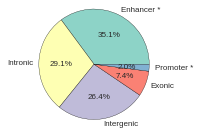

In [62]:
#Make piechart
f,axes = plt.subplots(1,1,figsize=(2,2))
age_regions_pct.plot.pie(ax=axes,autopct='%1.1f%%',colors=sns.color_palette("Set3",n_colors=5),labels = [[x,x+' *'][x in ['Enhancer','Promoter']] for x in age_regions_pct.index],fontsize=8)
axes.set_ylabel('')
axes.axis('equal')

In [63]:
#Save to file
age_regions_pct.to_csv('data/epigenetic_aging_model/EnetSites_annotatedgenic_features.csv',index=True)

(-1.0075192262668253, 1.0, -1.005648524268939, 1.0103375844442652)

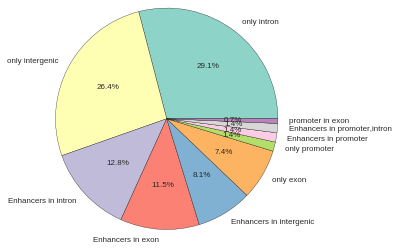

In [64]:
#age_regions with specific detail, see that enhancers overlap a lot of different genomic features 
f,axes = plt.subplots(1,1,figsize=(4,4))
age_regions_pct_detail = age_regions['SpecificDetail'].value_counts()/age_regions['SpecificDetail'].value_counts().sum()
age_regions_pct_detail.plot.pie(ax=axes,autopct='%1.1f%%',colors=sns.color_palette("Set3",n_colors=age_regions['SpecificDetail'].unique().shape[0]),fontsize=8)
axes.set_ylabel('')
axes.axis('equal')

Enrichment p-value calculation by permutations of all unique genomic regions

In [65]:
import random
import collections

In [66]:
m = 10000
nsamp = 148
permuts = []
for x in xrange(m):
    samp = random.sample(unique_genomic_regions['RegionName'].values,148)
    permuts.append(samp)

In [67]:
random_permuts = collections.defaultdict(list)

In [68]:
for perm in permuts:
    count_dict = collections.Counter(perm)
    for key in count_dict:
        random_permuts[key].append(count_dict[key])

In [69]:
summary_series = []
for key in random_permuts.keys():
    summary_series.append(np.mean(random_permuts[key])/nsamp)
summary_series = pd.Series(summary_series,index=random_permuts.keys())

In [70]:
summary_series

Enhancer      0.204355
Intergenic    0.298477
Intronic      0.295016
Exonic        0.124944
Promoter      0.077208
dtype: float64

In [71]:
counts_actual = collections.Counter(age_regions['RegionName'])

In [72]:
gt_series = []
for key in random_permuts.keys():
    array_ver = np.array(random_permuts[key])
    sum_greater = (array_ver > counts_actual[key]).sum()
    gt_series.append(sum_greater)
gt_series = pd.Series(gt_series,index = random_permuts.keys())

In [73]:
#Still see under-enrichment in promotoers and over-enrichment in enhancers
gt_series/m

Enhancer      0.0000
Intergenic    0.8015
Intronic      0.5124
Exonic        0.9671
Promoter      0.9981
dtype: float64

In [74]:
#See enrichment over random.
age_regions_pct/summary_series

Enhancer      1.719321
Exonic        0.594861
Intergenic    0.882860
Intronic      0.984829
Promoter      0.262541
dtype: float64